# HW6 Programming: n-Step TD, On- and Off-Policy

**Paired Submission:** If you intend to work on this assignment with a partner, please form your pair _before_ you begin and work collaboratively on every written question and every component of the programming assignment. Make sure both partners are listed as group members on the last submissions to Gradescope.

**Your assignment is to:** implement $n$-step Sarsa and the $n$-step Tree Backup algorithm with the greedy target policy (which we might call $n$-step Q-learning).

There's a twist: I won't be providing you with any starter code! 😲

You are, however, encouraged to use and adapt code from previous assignments (HW5 should be especially helpful).

The text cells below will guide you.

**You should start by duplicating this notebook:**
  - To save to your Google Drive, choose _File/Save a Copy in Drive…_ (from there you can open the file in Colab)
  - To save to your local machine, choose _File/Download/Download .ipnb_ (from there you can open the file in your favorite editor for notebooks)

When you submit, you will download the _.ipnb_ file and then upload it to Gradescope (details below).

# Imports

Import anything you need here

In [15]:
# Do not change the contents of this cell!

import math
import numpy as np
import random
from collections import namedtuple

from tqdm.notebook import trange, tqdm  # To get nice progress bars

%config InlineBackend.figure_formats = ['jpeg']
%matplotlib inline
import matplotlib.pyplot as plt         # For plotting
import seaborn as sns

plt.rcParams['figure.dpi'] = 50

# Supporting Classes

You'll probably need classes to represent MDPs and policies etc.

Please keep your notebook well-organized:


*   Don't just dump all the code in one giant code cell
*   Don't just have a bunch of code cells one after the other
*   Do briefly explain each cell using text



# MDP and Policy Classes

Here we will define our MDP and Policy classes, which are the same as in past assignments.

Feel free to breeze on through here.

In [16]:
# Do not change the contents of this cell!

# This cell imports the basic MDP parent class

RandomVar = namedtuple("RandomVar", "values,probs")

class MDP:
  """Represents an MDP (environment).  Has two instance variables: states and
  actions which are arrays of all possible states and actions."""
  def __init__(self, states, actions):
    self.states = states
    self.actions = actions

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    raise NotImplementedError

  def takeAction(self, s, a):
    """Given a state and action, returns a (next state, reward) pair, randomly
    selected according to the probabilities given by resultsFor"""
    randomNum = random.random()
    totalProb = 0
    results = self.resultsFor(s, a)
    for sprime, rwd in results:
      totalProb += results[(sprime, rwd)]
      if totalProb > randomNum:
        return (sprime, rwd)
    # Shouldn't get here!
    print("Something's wrong: transition probabilities don't add to 1!")
    return None

  def getInitialState(self):
    """Randomly selects and returns an initial state."""
    raise NotImplementedError

  def formatv(self, v):
    """Returns an easy-to-read representation of the value function."""
    return str(v)

  def formatq(self, q):
    """Returns an easy-to-read representation of the value function."""
    return str(q)

  def formatpi(self, pi):
    """Returns an easy-to-read representation of the policy."""
    return str(pi)

In [17]:
# Please do not change the contents of this cell!

# This cell block imports the basic parent Policy class

class Policy:
  def __init__(self, mdp):
    self.mdp = mdp

  def actionsFor(self, state):
    """ Returns a dictionary keyed by actions, whose associated value
    is the probability of choosing that action.

    This is similar to the pi(a | s) function."""
    raise NotImplementedError

  def chooseAction(self, state):
    """ Returns an action, randomly selected using the distribution given by
    actionsFor"""
    randomNum = random.random()
    totalProb = 0
    actions = self.actionsFor(state)
    for a in actions:
      totalProb += actions[a]
      if totalProb > randomNum:
        return a
    # Shouldn't get here!
    print("Something's wrong: transition probabilities don't add to 1!")
    return None

  def __str__(self):
    """Returns the desired action for each state."""
    return str({s: self.actionsFor(s) for s in self.mdp.states})

In [18]:
# This cell block extends the Policy class for EpsilonGreedyPolicy

class EpsilonGreedyPolicy(Policy):
  def __init__(self, mdp, q, epsilon):
    super().__init__(mdp)
    self.q = q # We do NOT make a copy of q, so behavior will change as q changes
    self.epsilon = epsilon

  def actionsFor(self, state):
    X = random.random()
    N = len(self.mdp.actions)
    
    a= {}
    # getting the actions for only the state we are in
    state_actions = [(s, a) for (s, a) in self.q.keys() if s == state]
    ga = max(state_actions, key=lambda sa: self.q[sa])[1]
    for action in self.mdp.actions:
      a[action] = self.epsilon / N
      if action == ga:
        a[action] += (1 - self.epsilon)
    return a

In [19]:
# code to generate an episode for our policy evalulation

Episode = namedtuple("Episode", "states, actions, rewards")

def generateEpisode(mdp, pi, initS, initA=None, maxSteps: int = 100):
    """Take an MDP mdp, Policy pi, and state initS and generate an episode by
    following policy pi in mdp, starting with initS.

    The optional parameter initA specifies the initial action (default None,
    in which case the initial action is selected by pi).

    Returns an Episode containing the states, actions, and rewards generated"""
    curS = initS
    if initA != None:
      a = initA
    else:
      a = pi.chooseAction(curS)

    ep = Episode([curS], [a], [None])

    ### counter can't go above 100
    counter = 0

    while curS != None and counter < maxSteps:                   # While the episode has not terminated
      curS, rwd = mdp.takeAction(curS, a) # Get the outcome
      ep.rewards.append(rwd)              # Record the reward obtained
      if curS != None:                    # If the episode hasn't terminated
        ep.states.append(curS)            # Record the next state
        a = pi.chooseAction(curS)         # Choose the next action
        ep.actions.append(a)              # Record the next action

      # update counter
      counter += 1
    return ep, ep.rewards


# Cliff Walk

You'll be experimenting with the Cliff Walk problem. Remember it from HW5? Here would be a good place to define it.

In [20]:
# Do not change the contents of this cell!

# CliffWalk class from the preivous homework

class CliffWalk(MDP):
  def __init__(self):
    super().__init__([(x,y) for x in range(12) for y in range(4)],
                     ["R", "D", "U", "L"])
    self.width = 12
    self.height = 4

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    x, y = s
    newX = x
    newY = y

    if a == "R":
      newX = x + 1
    elif a == "D":
      newY = y - 1
    elif a == "U":
      newY = y + 1
    elif a == "L":
      newX = x - 1

    if newX < 0 or \
       newX >= self.width or \
       newY < 0 or \
       newY >= self.height:
      newX = x
      newY = y

    if newY == 0 and newX > 0:
      if newX < self.width - 1:
        return {((0, 0), -100) : 1}
      else:
        return {(None, -1): 1}
    else:
      return {((newX, newY), -1) : 1}

  def getInitialState(self):
    """Selects and returns an initial state."""
    return (0, 0)

  def formatq(self, q):
    lines = []
    for y in range(self.height-1, -1, -1):
      line = ""
      for x in range(self.width):
        acts = self.actions
        for a in acts:
          line += a + "(" + str(q[(x, y), a]) + ")"
        line += " | "
      lines.append(line)
    return "\n".join(lines)

  def formatpi(self, pi):
    lines = []
    for y in range(self.height-1, -1, -1):
      line = ""
      for x in range(self.width):
        mostLikelyAct = None
        maxProb = 0
        acts = pi.actionsFor((x, y))
        for a in acts:
          if acts[a] > maxProb:
            maxProb = acts[a]
            mostLikelyAct = a
        line += mostLikelyAct
      lines.append(line)
    return "\n".join(lines)

cliff = CliffWalk()

# $n$-Step Sarsa

Here's a good spot to implement $n$-step Sarsa.

## Evaluation episodes
For every episode of learning, your implementation should also do one _evaluation_ episode, during which there is no learning and the behavior is entirely greedy ($\epsilon = 0$). Your implementation should, at the very least, grant you access to the agent's total summed reward for every learning episode and for every evaluation episode, so you can examine these later.

It is possible for the agent to learn a greedy policy with a loop, which would therefore never reach the terminal state. You should limit evaluation episodes to a maximum of 100 steps. (Do not limit the length of learning episodes).

## Additional guidelines:

*   It's okay if your implementation remembers the entire episode (i.e. you don't need to limit your stored data to $n$ steps).
*   You'll need to be able to easily set $\epsilon$, $\alpha$, and $n$ as paremeters.
*   I highly encourage you to test your implementation on a small scale example (e.g. previous assignments have value estimates for `SimpleMDP` under various conditions).



In [21]:
# n_step_sarsa inputs: 
#    step size alpha (0, 1]
#    positive epsilon
#    number of steps n > 0 int
def n_step_sarsa(mdp: MDP, n: int = 1, numepisodes: int = 10000, gamma: float = 1, epsilon: float =0.1, alpha: float =0.1, progressBar: bool =True, printEp: bool =False):
    """Take an MDP mdp and return
     - The agent's policy after training
     - The agent's value function after training
     - A list of total rewards for each episode during training

     Optional parameters:
     - numEpisodes (default 10000): number of episodes to perform
     - gamma (default 1): the discount rate
     - epsilon (default 0.1): the exploration rate
          # loop for each step t
     - n (default 1): number of steps algorithm will take for each G update
   - alpha (default 0.1): the step size
     - progressBar (default True): if True, displays a progress bar counting training episodes
     - printEp (default False): if True, prints updates and policies during training"""

    # init Q(s,a) and Q(terminal, a) = 0
    q = {(s, a): 0 for s in mdp.states for a in mdp.actions} 

    # init episode scores
    epScores = []

    # episode evals array to keep track of all the epsidoes were evaluating
    evals = []

    # Generate epsilongreedypolicy based on q
    pi = EpsilonGreedyPolicy(mdp, q, epsilon)

    # eval policy
    eval_pi = EpsilonGreedyPolicy(mdp, q, 0)
 


    # loop forever (over episodes)
    for i in tqdm(range(numepisodes), desc="n-step Sarsa Eps", disable=not progressBar):

        # init state, action, reward arrays
        states = []
        actions = []
        rewards = [0]

        epScores.append(0)

        # init S_0
        curS = mdp.getInitialState()

        # choose action A_0 for S_0 based on policy \pi based on Q
        curA = pi.chooseAction(curS)

        # add to the states and actions arrays
        states.append(curS)
        actions.append(curA)

        # init step
        step = 0
        T = float('inf') # allows us to keep looping until we have found the terminal state

        while True:
            if step < T:
                # take action A_t, observe R_t+1 and S_t+1
                
                nextS, r = mdp.takeAction(curS, curA)

                # adding to arrays
                states.append(nextS)
                rewards.append(r)
                
                # update epScores
                epScores[-1] += r

                if not nextS:
                    # have reached the terminal state so we can update the T value from "infinity"
                    T = step+1
                else:
                    # choose the next action and from the state
                    nextA = pi.chooseAction(nextS)
                    actions.append(nextA)

                    # Update current state and action
                    curS = nextS
                    curA = nextA
            # Calculate tau
            tau = step - n + 1

            if tau >= 0:
                # get discounted return from tau : tau + n
                G = sum([pow(gamma, i - tau - 1)*rewards[i] for i in range(tau+1, min(tau + n + 1, T))])

                if tau + n < T:
                    G += pow(gamma, n) * q[(states[tau + n], actions[tau + n])]

                # update Q(S_tau, A_tau) based on sarsa update equation
                q[(states[tau], actions[tau])] += alpha * (G - q[(states[tau], actions[tau])])
            
            step += 1

            # until s_tau is about to become the terminal state
            if tau == T - 1:
                break

        """
        For every episode of learning, your implementation should also do one _evaluation_ episode, 
        during which there is no learning and the behavior is entirely greedy ($epsilon = 0$). 
        Your implementation should, at the very least, grant you access to the agent's total summed reward for every
        learning episode and for every evaluation episode, so you can examine these later. 
        """
        # Eval the current policy
        _, eval_rewards = generateEpisode(mdp, eval_pi, mdp.getInitialState(), maxSteps = 100)
        evals.append(sum(eval_rewards[1:]))
        

    return pi, q, epScores, evals

# Experiment with $n$-step Sarsa

Run $n$-step Sarsa on the Cliff Walk MDP, varying $\alpha$, and $n$. In particular, with $\epsilon = 0.1$, try all combinations of:

- $\alpha = 0.1, 0.2, 0.4$
- $n = 1, 5$

You'll be looking the step size that works best for each value of $n$.

## Area under the curve
Unfortunately "best" is hard to define. We care about both how quickly the learning curve goes up and how high it gets by the end. As we've seen in the past, each of these is best achieved by higher and lower stepsizes, respectively, so they are not necessarily compatible goals!

One measure that is used fairly commonly is "area under the curve" (or AUC). It is simply the sum of the returns over all of the episodes, which approximates the area under the learning curve. If the curve rises quickly and levels off high, then the area will be large; if it rises slowly or levels off low, then the area will be small.

AUC has limitations (for instance it can't distinguish between a curve that rises high and then plummets back down from a curve that with modest but steady performance), but it's a reasonable summary statistic to compare curves that are mostly monotonically rising.

## Todo:
For each pair of values for $\alpha$ and $n$, run Sarsa for 200 episodes and, over 100 independent trials, average the AUC of the learning episodes and the AUC of the evaluation episodes. You should print out the both AUCs for each combination of $n$ and $\alpha$ (please include clear labels in your output).

This should only take a couple of minutes (or less) to run. If your implementation is uncomfortably slow, considering going back to improve the efficiency of your code.


In [22]:
# Do not change the contents of this cell!

# sarsaPi, sarsaQ, sarsaScores, evals = n_step_sarsa(cliff, epsilon = 0.1, alpha = 0.1, n = 1)
# print("Policy (most likely action):")
# print(cliff.formatpi(sarsaPi))

alphas = [0.1, 0.2, 0.4]
ns = [1, 5]
epsilon = 0.1

for alpha in alphas:
    for n in ns:
        learn_AUC = []
        eval_AUC = []
        # 
        for _ in range(100):
            pi, q, epScores, evals = n_step_sarsa(cliff, epsilon= epsilon, n= n, alpha = alpha, numepisodes= 200, progressBar= False)

            # epScores stores the sum of the rewards for each episode in a list
            learn_AUC.append(sum(epScores))
            
            # evals holds the rewards from each eval after episode
            eval_AUC.append(sum(evals))

        # at the end of this for loop block learn_AUC and eval_AUC will contain 100 AUC calculations for the given alpha and n. We need to average the value then print it
        avg_learn_AUC = sum(learn_AUC) / len (learn_AUC)
        avg_eval_AUC = sum(eval_AUC) / len (eval_AUC)

        print(f"n: {n} alpha: {alpha} learning auc: {avg_learn_AUC} eval acu: {avg_eval_AUC}")


n: 1 alpha: 0.1 learning auc: -16683.78 eval acu: -19509.79
n: 5 alpha: 0.1 learning auc: -11026.29 eval acu: -6084.06
n: 1 alpha: 0.2 learning auc: -11991.51 eval acu: -15902.55
n: 5 alpha: 0.2 learning auc: -11142.56 eval acu: -6014.19
n: 1 alpha: 0.4 learning auc: -9835.31 eval acu: -12207.72
n: 5 alpha: 0.4 learning auc: -13108.02 eval acu: -9334.01


For your reference, here is my output. Yours will probably differ. You might even see a different ordering of AUCs, since some numbers are a little close. Still, if your numbers are not in the ballpark, something is probably wrong.
```
n: 5 alpha: 0.1 learning auc: -11461.969999999654 eval auc: -6399.1799999995455
n: 5 alpha: 0.2 learning auc: -10942.529999999506 eval auc: -6409.929999999128
n: 5 alpha: 0.4 learning auc: -13037.199999999757 eval auc: -10086.989999998694

n: 1 alpha: 0.1 learning auc: -18182.79999999991 eval auc: -19889.14000000202
n: 1 alpha: 0.2 learning auc: -12886.249999999683 eval auc: -16194.679999996699
n: 1 alpha: 0.4 learning auc: -10374.379999999857 eval auc: -12648.419999998516
```

# $n$-Step Q-learning (Tree Backup)

Here you can implement the Tree Backup algorithm, specifically with the greedy policy as the target policy (i.e. the target policy always chooses the action that maximizes $Q$). We can think of this as $n$-step Q-learning.

Just as above, your implementation should do one evaluation episode for every learning episode.

## Additional Guidelines

*   Take your time! The Tree Backup algorithm is tricky! I highly recommend coding alongside pen and paper so you can keep track of your indices etc.
*   It's okay if your implementation remembers the entire episode (i.e. you don't need to limit your stored data to $n$ steps).
*   You'll need to be able to easily set $\epsilon$, $\alpha$, and $n$ as paremeters.
*   I highly encourage you to test your implementation on a small scale example (e.g. previous assignments have value estimates for `SimpleMDP` under various conditions).



In [23]:
# n-step q-learning (tree backup) algorithm

# TODO: Implement tree back up
# tree backup inputs: 
#    step size alpha (0, 1]
#    positive epsilon
#    number of steps n > 0 int
def treeBackup(mdp: MDP, n: int = 1, numepisodes: int = 10000, gamma: float = 1, epsilon: float =0.1, alpha: float =0.1, progressBar: bool =True, printEp: bool =False):
    """Take an MDP mdp and return
     - The agent's policy after training
     - The agent's value function after training
     - A list of total rewards for each episode during training

     Optional parameters:
     - numEpisodes (default 10000): number of episodes to perform
     - gamma (default 1): the discount rate
     - epsilon (default 0.1): the exploration rate
          # loop for each step t
     - n (default 1): number of steps algorithm will take for each G update
   - alpha (default 0.1): the step size
     - progressBar (default True): if True, displays a progress bar counting training episodes
     - printEp (default False): if True, prints updates and policies during training"""

    # init Q(s,a) and Q(terminal, a) = 0
    q = {(s, a): 0 for s in mdp.states for a in mdp.actions} 

    # init episode scores
    epScores = []

    # episode evals array to keep track of all the epsidoes were evaluating
    evals = []

    # Generate epsilongreedypolicy based on q
    pi = EpsilonGreedyPolicy(mdp, q, epsilon)

    # eval policy
    eval_pi = EpsilonGreedyPolicy(mdp, q, 0)
 
    # loop numepisodes times
    for i in tqdm(range(numepisodes), desc="n-step Sarsa Eps", disable=not progressBar):

        # init state, action, reward arrays
        states = []
        actions = []
        rewards = [0]

        epScores.append(0)

        # init S_0
        curS = mdp.getInitialState()

        # choose action A_0 for S_0 based on policy \pi based on Q
        curA = pi.chooseAction(curS)

        # add to the states and actions arrays
        states.append(curS)
        actions.append(curA)

        # init step
        step = 0
        T = float('inf') # allows us to keep looping until we have found the terminal state

        while True:
            if step < T:
                # take action A_t, observe R_t+1 and S_t+1
                nextS, r = mdp.takeAction(curS, curA)

                # adding to arrays
                states.append(nextS)
                rewards.append(r)
                
                # update epScores
                epScores[-1] += r

                if not nextS:
                    # have reached the terminal state so we can update the T value from "infinity"
                    T = step+1
                else:
                    # choose the next action and from the state
                    nextA = pi.chooseAction(nextS)
                    actions.append(nextA)

                    # Update current state and action
                    curS = nextS
                    curA = nextA
            # Calculate tau
            tau = step - n + 1

            if tau >= 0:
                # Check if t+1 is the terminal state
                if step + 1 >= T:
                    # update G to R_T (final reward)
                    G = rewards[T] # or maybe rewards[T-1]

                else:
                    # Set G to the next reward plus the Expected value of next state
                    nextStateActionsFor = pi.actionsFor(states[step + 1]) # get the action to probability map for S_t+1
                    G = rewards[step+1] + gamma * sum(prob * q[(states[step + 1], a)] for a, prob in nextStateActionsFor.items())

                # k = min(step, T-1)
                for k in range(min(step, T-1), tau, -1):
                    #looping from t down to tau (going back through looking at all the actions that we could have taken)
                    kStateActionsFor = pi.actionsFor(states[k])
                    A_kProb = kStateActionsFor[actions[k]] # get the prob of taking A_k in S_k using the kStateActionFor
                    G = rewards[k] + gamma * sum(prob * q[(states[k], a)] for a, prob in kStateActionsFor.items() if a != actions[k]) + gamma * A_kProb * G
                q[(states[tau], actions[tau])] += alpha * (G - q[(states[tau], actions[tau])])

            step += 1

            # until s_tau is about to become the terminal state
            if tau == T - 1:
                break

        """
        For every episode of learning, your implementation should also do one _evaluation_ episode, 
        during which there is no learning and the behavior is entirely greedy ($epsilon = 0$). 
        Your implementation should, at the very least, grant you access to the agent's total summed reward for every
        learning episode and for every evaluation episode, so you can examine these later. 
        """
        # Eval the current policy
        _, eval_rewards = generateEpisode(mdp, eval_pi, mdp.getInitialState(), maxSteps = 100)
        evals.append(sum(eval_rewards[1:]))
        

    return pi, q, epScores, evals

# Experiment with $n$-step Q-learning

Run $n$-step Q-learning on the Cliff Walk MDP, varying $\alpha$, and $n$. In particular, with $\epsilon = 0.1$, try all combinations of:

- $\alpha = 0.1, 0.2, 0.4$
- $n = 1, 5$

As before, for each combination of values of $\alpha$ and $n$, run 100 trials of 200 episodes each and print the average AUC for both learning and evaluation episodes (with clear labels).

In [24]:
# Do not change the contents of this cell!

# sarsaPi, sarsaQ, sarsaScores, evals = n_step_sarsa(cliff, epsilon = 0.1, alpha = 0.1, n = 1)
# print("Policy (most likely action):")
# print(cliff.formatpi(sarsaPi))

alphas = [0.1, 0.2, 0.4]
ns = [1, 5]
epsilon = 0.1

for alpha in alphas:
    for n in ns:
        learn_AUC = []
        eval_AUC = []
        # 
        for _ in range(100):
            pi, q, epScores, evals = treeBackup(cliff, epsilon= epsilon, n= n, alpha = alpha, numepisodes= 200, progressBar= False)

            # epScores stores the sum of the rewards for each episode in a list
            learn_AUC.append(sum(epScores))
            
            # evals holds the rewards from each eval after episode
            eval_AUC.append(sum(evals))

        # at the end of this for loop block learn_AUC and eval_AUC will contain 100 AUC calculations for the given alpha and n. We need to average the value then print it
        avg_learn_AUC = sum(learn_AUC) / len (learn_AUC)
        avg_eval_AUC = sum(eval_AUC) / len (eval_AUC)

        print(f"n: {n} alpha: {alpha} learning auc: {avg_learn_AUC} eval acu: {avg_eval_AUC}")


n: 1 alpha: 0.1 learning auc: -17545.8 eval acu: -19411.11
n: 5 alpha: 0.1 learning auc: -11948.03 eval acu: -6877.46
n: 1 alpha: 0.2 learning auc: -11741.29 eval acu: -14094.93
n: 5 alpha: 0.2 learning auc: -10176.03 eval acu: -5312.61
n: 1 alpha: 0.4 learning auc: -8516.75 eval acu: -9251.37
n: 5 alpha: 0.4 learning auc: -10600.23 eval acu: -4294.43


Here is my output. If your numbers are way off, something is probably wrong!
```
n: 5 alpha: 0.1 learning AUC: -15311.459999998753 eval AUC: -5474.410000000232
n: 5 alpha: 0.2 learning AUC: -14044.66999999922 eval AUC: -4312.3100000009645
n: 5 alpha: 0.4 learning AUC: -13688.899999998841 eval AUC: -3842.910000001054

n: 1 alpha: 0.1 learning AUC: -20278.499999999694 eval AUC: -19139.97000000123
n: 1 alpha: 0.2 learning AUC: -15688.90999999841 eval AUC: -12758.829999996058
n: 1 alpha: 0.4 learning AUC: -13406.119999998002 eval AUC: -7867.710000000372
```

# Performance Comparison

Now you'll compare four algorithms in the Cliff Walk:

- 1-step Sarsa
- 1-step Q-learning
- 5-step Sarsa
- 5-step Q-learning

## Compare the algorithms at their best

For each one of these, identify the best performing value of $\alpha$. For the purpose of this experiment, we will pick the value of $\alpha$ that gave the best AUC in the _learning_ episodes.

## Re-run the results

We shouldn't just take the results you already generated from your selected $\alpha$ value. If we do that, we might accidentally be cherry picking a particularly lucky result that isn't representative.

So, for each algorithm, run it again with the selected $\alpha$ for 200 episodes over 100 trials.

## Plot your results

Plot learning curves for the four algorithms. You should have two plots, one that shows performance during learning episodes, and one that shows performance during evaluation episodes.

For reference, you can see my final results below. You can see that our empirical observations match our theoretical expectations:

- Sarsa ultimately gets more reward during learning episodes (because Q-learning causes the agent to stay close to the cliff and suffers from exploratory actions).
- Q-learning gets more reward during evaluation episodes, even achieving optimal performance (because Sarsa learns the best $\epsilon$-soft policy, not the optimal policy).
- The 5-step algorithms learn good policies faster than the 1-step algorithms (because they propagate value information faster).
- 1-step Sarsa ultimately finds a better $\epsilon$-soft policy than 5-step Sarsa and 1-step Q-learning ultimately finds a better greedy policy than 5-step Q-learning. Because of their higher update variance, the 5-step algorithms probably need much lower step sizes (and longer to learn) to achieve the same long-term performance.

If your results are very different, especially if these qualitative observations don't match your findings, something is probably wrong. Consider going back to carefully test your algorithms.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# - 1-step Sarsa best alpha: 0.4
# - 1-step Q-learning best alpha: 0.4
# - 5-step Sarsa best alpha: 0.2
# - 5-step Q-learning best alpha: 0.2

alphas = [0.4, 0.2]
ns = [1, 5]
epsilon = 0.1

# For storing results for plotting
sarsa_results = {}
treebackup_results = {}

# N-step SARSA
for i in range(2):
    all_learn_scores = []  # Will store 100 lists of 200 episode scores each
    all_eval_scores = []   # Will store 100 lists of 200 eval scores each
    
    for _ in range(100):
        pi, q, epScores, evals = n_step_sarsa(cliff, epsilon=epsilon, n=ns[i], 
                                            alpha=alphas[i], numepisodes=200, progressBar=False)
        all_learn_scores.append(epScores)  # epScores should be a list of 200 scores
        all_eval_scores.append(evals)      # evals should be a list of 200 eval scores
    
    # Convert to numpy arrays and calculate mean across runs for each episode
    all_learn_scores = np.array(all_learn_scores)  # Shape: (100, 200)
    all_eval_scores = np.array(all_eval_scores)    # Shape: (100, 200)
    
    avg_learn_scores = np.mean(all_learn_scores, axis=0)  # Average across 100 runs for each episode
    avg_eval_scores = np.mean(all_eval_scores, axis=0)    # Average across 100 runs for each episode
    
    # Store results
    sarsa_results[f'n{ns[i]}'] = {
        'learn': avg_learn_scores,
        'eval': avg_eval_scores,
        'alpha': alphas[i]
    }
    
    print(f"n_step_sarsa: n={ns[i]}, alpha={alphas[i]}")
    print(f"Learning AUC: {np.sum(avg_learn_scores):.2f}")
    print(f"Eval AUC: {np.sum(avg_eval_scores):.2f}")

# Tree Backup
for i in range(2):
    all_learn_scores = []
    all_eval_scores = []
    
    for run in range(100):
        pi, q, epScores, evals = treeBackup(cliff, epsilon=epsilon, n=ns[i], 
                                          alpha=alphas[i], numepisodes=200, progressBar=False)
        all_learn_scores.append(epScores)
        all_eval_scores.append(evals)
    
    all_learn_scores = np.array(all_learn_scores)
    all_eval_scores = np.array(all_eval_scores)
    
    avg_learn_scores = np.mean(all_learn_scores, axis=0)
    avg_eval_scores = np.mean(all_eval_scores, axis=0)
    
    # Store results
    treebackup_results[f'n{ns[i]}'] = {
        'learn': avg_learn_scores,
        'eval': avg_eval_scores,
        'alpha': alphas[i]
    }
    
    print(f"treeBackup: n={ns[i]}, alpha={alphas[i]}")
    print(f"Learning AUC: {np.sum(avg_learn_scores):.2f}")
    print(f"Eval AUC: {np.sum(avg_eval_scores):.2f}")

# Create the plots
episodes = range(1, 201)  # Episodes 1 to 200



n_step_sarsa: n=1, alpha=0.4
Learning AUC: -9859.26
Eval AUC: -12210.82
n_step_sarsa: n=5, alpha=0.2
Learning AUC: -10923.20
Eval AUC: -5733.62
treeBackup: n=1, alpha=0.4
Learning AUC: -8593.24
Eval AUC: -9092.21
treeBackup: n=5, alpha=0.2
Learning AUC: -10419.20
Eval AUC: -5022.32


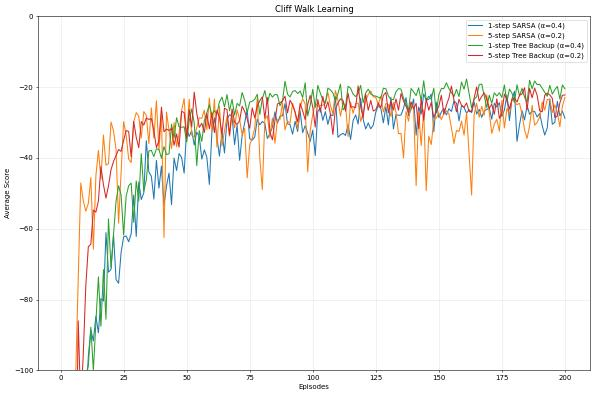

In [35]:
# Plot learning curves
plt.figure(figsize=(12, 8))

# plt.subplot(1, 2, 1)
plt.plot(episodes, sarsa_results['n1']['learn'], label=f"1-step SARSA (α={sarsa_results['n1']['alpha']})")
plt.plot(episodes, sarsa_results['n5']['learn'], label=f"5-step SARSA (α={sarsa_results['n5']['alpha']})")
plt.plot(episodes, treebackup_results['n1']['learn'], label=f"1-step Tree Backup (α={treebackup_results['n1']['alpha']})")
plt.plot(episodes, treebackup_results['n5']['learn'], label=f"5-step Tree Backup (α={treebackup_results['n5']['alpha']})")
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Cliff Walk Learning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-100, 0)



plt.tight_layout()
plt.show()

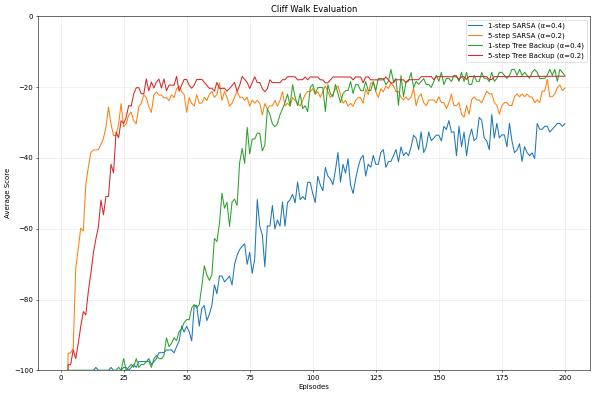

In [34]:
# Plot learning curves
plt.figure(figsize=(12, 8))

# plt.subplot(1, 2, 2)
plt.plot(episodes, sarsa_results['n1']['eval'], label=f"1-step SARSA (α={sarsa_results['n1']['alpha']})")
plt.plot(episodes, sarsa_results['n5']['eval'], label=f"5-step SARSA (α={sarsa_results['n5']['alpha']})")
plt.plot(episodes, treebackup_results['n1']['eval'], label=f"1-step Tree Backup (α={treebackup_results['n1']['alpha']})")
plt.plot(episodes, treebackup_results['n5']['eval'], label=f"5-step Tree Backup (α={treebackup_results['n5']['alpha']})")
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.title('Cliff Walk Evaluation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-100, 0)

plt.tight_layout()
plt.show()

## Learning Episodes
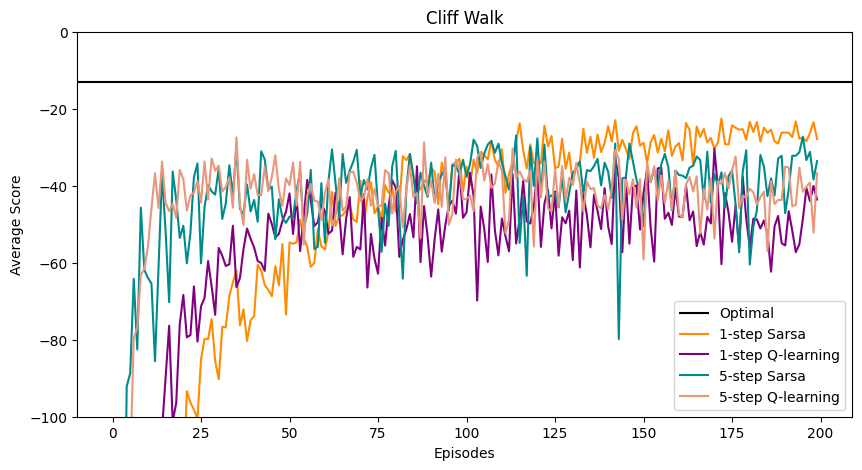
##Evaluation Episodes
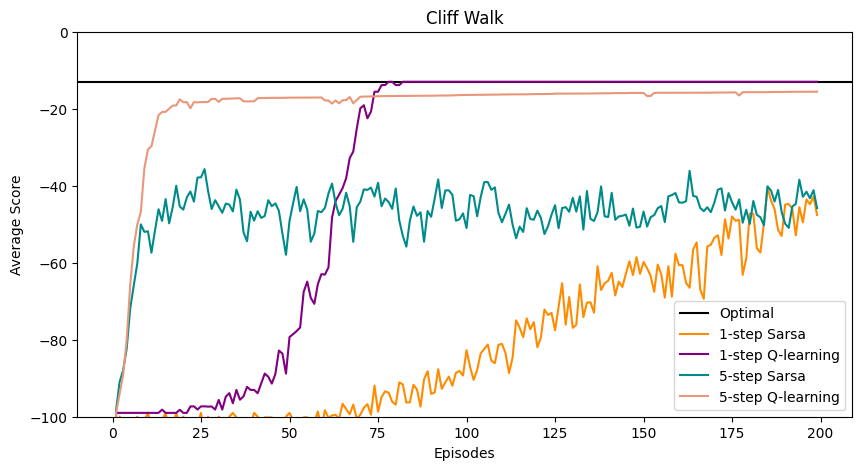

# TODO: Submit!

1. Make sure that the output of all cells is up-to-date (easiest way is to choose _Runtime/Run all_).
2. If you are working in Colab, choose _File/Download/Download .ipnb_ (otherwise locate your _.ipnb_ file)
3. Go to the Gradescope assignment to submit.
4. Choose _Upload_ as the submission method and upload your _.ipnb_ file.
5. If you are working as a pair, make sure to push the _Group Members_ button to add the other partner.